# Simulación del tráfico en un carril.

Primero se simulará para dos carros. La ecuación que simulará la velocidad de los vehículos es el mínimo entre

$$\dot{x_i} = \frac{1}{T_i}(x_{i-1}-x_i -\frac{l_i + l_{i-1}}{2}) 
$$ 

y

$$ \dot{x_i} = v_{max_{i}} $$

In [2]:
#Llamando al paquete de Taylor
using TaylorSeries

In [3]:
#Definiendo parámetros. Sólo para fijar ideas.

x1_0 = 0.0;
x2_0 = pi;
l1 = pi/16;
l2 = l1;
V1 = pi/4;
V2 = pi/2;

per1=1;
per2=1;



A continuación se escribe la función `modulo2pi` que encuentra la diferencia entre dos ángulos en módulo 2$\pi$

In [4]:
function modulo2pi(α,β)
    #Esta función calcula la diferencia entre dos ángulos y la devuelve 
    #módulo 2π.
    δ=α-β 
    
    if δ<0
        δ = 2π + δ
    else 
        δ = δ 
    end
    
    return δ
end

modulo2pi (generic function with 1 method)

In [5]:
#La siguiente función calcula los coeficientes de la velocidad de seguridad

function fSec{R<:Real }(T::R, car::TaylorSeries.Taylor1{R}, frontcar::TaylorSeries.Taylor1{R} , lfcar::R, Vmax::R)
    k = max(car.order, frontcar.order)
    
    vel = taylor1_variable(Float64, k)
     
    vel.coeffs[1] = 1/T * modulo2pi(frontcar.coeffs[1]-lfcar,car.coeffs[1])
    
    for i = 2 : k+1
        vel.coeffs[i] = 1/T * (frontcar.coeffs[i]-car.coeffs[i])
    end
        
    
    return vel
end

function fmax{R<:Real}(T::R, car::TaylorSeries.Taylor1{R}, frontcar::TaylorSeries.Taylor1{R} , lfcar::R, Vmax::R)
    vel = taylor1_variable(Float64,10)
    
    vel.coeffs[1] = Vmax
    vel.coeffs[2] = 0
    return vel
end


fmax (generic function with 1 method)

Ahora se definen un par de variables tipo `Taylor1` que tendrá información de las series de taylor de las funciones $x_1 (t)$ y $x_2 (t)$.

Ahora, a encontrar los siguientes coeficientes. Usando que 
$$ x_{n+1} = \frac{f_n}{n+1} $$

Es momento de avanzar. definamos la épsilon y la función para calcular el siguiente paso.

Sabemos que el paso siguiente está dado por 
$$ h = \min\big[\, \big(\frac{\epsilon}{x^{[p-1]}}\big)^{1/(p-1)}, \big(\frac{\epsilon}{x^{[p]}}\big)^{1/p}\, \big] $$

In [6]:
function stepsize{T<:Real}(x::TaylorSeries.Taylor1{T}, epsilon::Float64)
    ord = x.order
    h = Inf
    
    if ord > 1
        
        for k in [ord-1, ord]
            kinv = 1.0/k
            aux = abs( x.coeffs[k+1] )
            h = min(h, (epsilon/aux)^kinv)
        end
    
    elseif ord == 1
        
        
        
        aux = abs( x.coeffs[2])
        
        h = min(h, (epsilon/aux))
        
    end
        
    
    
    return h
end

stepsize (generic function with 1 method)

Necesitamos una función que sólo con las condiciones iniciales (y otros parámetros) , calcule las series de dos coches.

In [7]:
function series(x10,x20,T1,T2,L1,L2,V1,V2)
   
    
    vel1 = 1/T1 * modulo2pi(x20-L2,x10)
    
    vel2 = 1/T2 * modulo2pi(x10-L1,x20)
    #Velocidades de seguridad.
    
    if vel1 < V1 && vel2 < V2
    
        x1 = taylor1_variable(Float64,20)
        x2 = taylor1_variable(Float64,20)
    
        x1.coeffs[1] = x10
        x1.coeffs[2] = 0
    
        x2.coeffs[1] = x20
        x2.coeffs[2] = 0
        
        for i = 2:20
            x1.coeffs[i] = velocidad_sec(T1,x1,x2,L2).coeffs[i-1]/i
            x2.coeffs[i] = velocidad_sec(T2,x2,x1,L1).coeffs[i-1]/i
        end
    
    
    elseif vel1 < V1 && vel2 > V2
        
        x1 = taylor1_variable(Float64,20)
        x2 = taylor1_variable(Float64,1)
        
        x1.coeffs[1] = x10
        x1.coeffs[2] = 0
        
        x2.coeffs[1] = x20
        
        
        x2.coeffs[2] = V2
        for i = 2:20
            x1.coeffs[i] = velocidad_sec(T1,x1,x2,L2).coeffs[i-1]/i
        end
        
    
    

    
    elseif vel1 > V1 && vel2 < V2
        
        x1 = taylor1_variable(Float64,1)
        x2 = taylor1_variable(Float64,20)
        
        x1.coeffs[1] = x10
        x1.coeffs[2] = V1
        
        x2.coeffs[1] = x20
        x2.coeffs[0] = 0
        
        for i = 2:20
            x2.coeffs[i] = velocidad_sec(T2,x2,x1,L1).coeffs[i-1]/i
        end
        
        
    
    
    elseif vel1 > V1 && vel2 > V2
        x1 = taylor1_variable(Float64,1)
        x2 = taylor1_variable(Float64,1)
        
        x1.coeffs[1] = x10
        x1.coeffs[2] = V1
        
        x2.coeffs[1] = x20
        x2.coeffs[2] = V2
        
    end
    
    return x1, x2
    
end
    
        
    
    
    
    

series (generic function with 1 method)

In [8]:
 x2 = taylor1_variable(Float64,1)
typeof(x2)

TaylorSeries.Taylor1{Float64}

In [9]:

#t1 y t2 son vectores donde se guardarán los tiempos donde se evalúa la función.
t1 = Float64[];
push!(t1,0);

#x1 y x2 son vectores donde se guardarán los valores de las funciones x1(t) y x2(t)

x1 = Float64[];
push!(x1,x1_0);
x2 = Float64[];
push!(x2,x2_0);




for n in 2:1000
    
    x1Taylor = series(x1_0,x2_0,per1,per2,l1,l2,V1,V2)[1]
    x2Taylor = series(x1_0,x2_0,per1,per2,l1,l2,V1,V2)[2]
    
    h1 = stepsize(x1Taylor,1.0e-5)
    
    h2 = stepsize(x2Taylor,1.0e-5)
    h = min(h1,h2)
    
    
    
    push!(t1,t1[n-1] + h)
    
    x1_0 = evaluate(x1Taylor,h)
    push!(x1,x1_0)
    x2_0 = evaluate(x2Taylor,h)
    push!(x2,x2_0)
    
end
    
    
    
    
    

In [10]:
x1

1000-element Array{Float64,1}:
 0.0     
 5.0e-6  
 1.0e-5  
 1.5e-5  
 2.0e-5  
 2.5e-5  
 3.0e-5  
 3.5e-5  
 4.0e-5  
 4.5e-5  
 5.0e-5  
 5.5e-5  
 6.0e-5  
 ⋮       
 0.00494 
 0.004945
 0.00495 
 0.004955
 0.00496 
 0.004965
 0.00497 
 0.004975
 0.00498 
 0.004985
 0.00499 
 0.004995

In [11]:
h = stepsize(x2,1.0e-20)

LoadError: LoadError: MethodError: `stepsize` has no method matching stepsize(::Array{Float64,1}, ::Float64)
Closest candidates are:
  stepsize{T<:Real}(!Matched::TaylorSeries.Taylor1{T<:Real}, ::Float64)
while loading In[11], in expression starting on line 1

In [12]:
t1
typeof(t1)

Array{Float64,1}

In [13]:
function speed(intPos::Array{Float64,1}, carL::Array{Float64,1}, carτ::Array{Float64,1}, carV::Array{Float64,1})
    #Esta función decide la función que debe generar la serie de cada carro.
    
    n = length(intPos)
    F = Function[]
   
    #F será un arreglo de funciones, una función para cada carro.
    
    for j in 1:n-1
        
        a = (modulo2pi(intPos[j+1],intPos[j])-carL[j+1])/carτ[j] #Checa la distancia al coche de enfrente.
        b = carV[j]
        
        if a < b #Compara las velocidades y decide que función aplicar al coche j
            push!(F,fSec)
        else
            push!(F,fmax)
        end
        
    end
    #El coche que está delante del enésimo es el coch 1. Se debe cerrar la cadena.
    
    a = (modulo2pi(intPos[1],intPos[n])-carL[1])/carτ[n]
    b = carV[n]
    
    if a < b
        push!(F,fSec)
    else
        push!(F,fmax)
    end
    
    return F
    
end

speed (generic function with 1 method)

In [14]:
X0 = [0,π,7*π/4];
L = π/16 * [1,1,1];
Τ = [1.0,1.0,1.0];
V = [π/4, π/2, 3*π/4]

3-element Array{Float64,1}:
 0.785398
 1.5708  
 2.35619 

In [15]:
F = speed(X0, L, Τ, V)

3-element Array{Function,1}:
 fmax
 fmax
 fSec

In [16]:
F[1](1.,x2,x2,1.,π/4)

LoadError: LoadError: MethodError: `fmax` has no method matching fmax(::Float64, ::Array{Float64,1}, ::Array{Float64,1}, ::Float64, ::Float64)
Closest candidates are:
  fmax{R<:Real}(::R<:Real, !Matched::TaylorSeries.Taylor1{R<:Real}, !Matched::TaylorSeries.Taylor1{R<:Real}, ::R<:Real, ::R<:Real)
while loading In[16], in expression starting on line 1

In [17]:
function Taylorcars(initPos::Array{Float64,1}, carL::Array{Float64,1}, carτ::Array{Float64,1}, carV::Array{Float64,1})
    
    n = length(initPos)
    
    Xcars = TaylorSeries.Taylor1{Float64}[]
    
    #El siguiente cilco llena el arreglo Xcars con taylors que sólo tienen el coeficiente de orden cero.
    for i in 1:n
        x = taylor1_variable(Float64,10)
        x.coeffs[1] = initPos[i]
        x.coeffs[2] = 0
        
        push!(Xcars,x)
    end
    
    #Se aplica la función speed para conocer la velocidad que tendrá cada carro
    F = speed(initPos::Array{Float64,1}, carL::Array{Float64,1}, carτ::Array{Float64,1}, carV::Array{Float64,1})
    
    #Una vez conociendo la velocidad se puede proseguir a calcular coeficientes de las series de taylor de órdenes mayores
    for i in 1:n-1
        for j in 2:11
            #Solo se aplica la fórmula de recurrencia.
            Xcars[i].coeffs[j] = F[i](carτ[i], Xcars[i], Xcars[i+1] , carL[i+1] , carV[i] ).coeffs[j-1]/(j-1) #se divide entre j-1 para corregir el desfase de los Taylor1 en los coeffs.
        end
    end
    
    #Al igual que con la velocidad, el último coche debe cerrar el ciclo. Tiene enfrente al coche 1.
    for j in 2:11
            
        Xcars[n].coeffs[j] = F[n](carτ[n], Xcars[n], Xcars[1] , carL[1] , carV[n] ).coeffs[j-1]/(j-1) #se divide entre j-1 para corregir el desfase de los Taylor1 en los coeffs.
    end
    
    return Xcars
    
end
    
    

Taylorcars (generic function with 1 method)

In [18]:
a=Taylorcars(X0, L, Τ, V)

3-element Array{TaylorSeries.Taylor1{Float64},1}:
                                                                                                                                                                                                                                                               0.7853981633974483 t + 𝒪(t¹¹)
                                                                                                                                                                                                                                           3.141592653589793 + 1.5707963267948966 t + 𝒪(t¹¹)
  5.497787143782138 + 0.589048622548086 t + 0.09817477042468115 t² - 0.03272492347489372 t³ + 0.00818123086872343 t⁴ - 0.0016362461737446858 t⁵ + 0.0002727076956241143 t⁶ - 3.895824223201633e-5 t⁷ + 4.869780279002041e-6 t⁸ - 5.410866976668934e-7 t⁹ + 5.410866976668934e-8 t¹⁰ + 𝒪(t¹¹)

In [19]:
diffTaylor(a[1])

 0.7853981633974483 + 𝒪(t¹¹)

In [20]:
#Seleccionamos el tamano de la h que vamos a usar para eso generamos un arreglo de h y elejiremos la más chica de ellas
#dada una épsilon
function hselector(seriecoches,ϵ)
    n=length(seriecoches)
    hs = Float64[]
    
    for i in 1:n
        h=stepsize(seriecoches[i],ϵ)
        push!(hs,h)
    end
    
    minabs(hs)
end

hselector (generic function with 1 method)

In [21]:
b=hselector(a,1.0e-3)

2.306589704437606

In [22]:
c=minabs(b)

2.306589704437606

In [135]:
function positions(tayse,h) #Calcula las nuevas posiciones
    x=Float64[];
    n=length(tayse)
    
    for i in 1:n
        pos= evaluate(tayse[i],h)
        push!(x,pos)
    end
    
    return x
end

function celeritates(tayse,h) #Calcula las nuevas velocidades
    v=Float64[];
    n=length(tayse)
    
    for i in 1:n
        ves= evaluate(diffTaylor(tayse[i]),0) #hace las primeras derivadas de las series de taylor de cada coche y las evalua
        push!(v,ves)
    end
    
    return v
end

celeritates (generic function with 1 method)

In [136]:
function pasamodulo2pi(arreglo)
    n=length(arreglo);
    nuevarreg = Float64[];
    for i in 1:n
        nueva = mod2pi(arreglo[i])
        push!(nuevarreg,nueva)
    end
    nuevarreg
end

pasamodulo2pi (generic function with 1 method)

In [137]:
pasamodulo2pi([π,2π,5π,7π/2])

4-element Array{Float64,1}:
 3.14159
 6.28319
 3.14159
 4.71239

In [138]:
positions(a,b)

3-element Array{Float64,1}:
 1.81159
 6.76478
 7.13263

In [139]:
celeritates(a,b)

3-element Array{Float64,1}:
 0.785398
 1.5708  
 0.589049

In [140]:
evaluate(diffTaylor(a[1]),b)

0.7853981633974483

In [185]:
#Ahora vamos a correr el método de Taylor.
function Taypos(X0, L, Τ, V,tf,ϵ,ti=0.0)
    tempore = Float64[ti]; #Arreglo de tiempo
    loca = Vector{Float64}[X0]; #Arreglo de arreglo de posiciones
    celerita = Vector{Float64}[V]; #Arreglo de arreglo de velocidades
    
    while ti <= tf
        tayseries = Taylorcars(X0, L, Τ, V)
        h = hselector(tayseries,ϵ)
        xs = positions(tayseries,h)
        #vs = celeritates(tayseries,h)
        ti = ti+h
        push!(tempore,ti)
        push!(loca,[pasamodulo2pi(xs);])
        push!(celerita, [V;])
        X0 = xs
        #V = vs
    end 
    
    [tempore hcat(loca...)' hcat(celerita...)';]
    
end


Taypos (generic function with 2 methods)

In [190]:
X0 = [0,π,7*π/4];
L = π/16 * [1,1,1];
Τ = [1.0,1.0,1.0];
V = [π, π/6, 3*π/6]
tf = 100;
ϵ = 2.0e-15;

In [191]:
grafdat = Taypos(X0, L, Τ, V,tf,ϵ)

1208x7 Array{Float64,2}:
   0.0        0.0       3.14159  5.49779    3.14159  0.523599  1.5708
   0.0681218  0.193954  3.17726  5.54311    3.14159  0.523599  1.5708
   0.136727   0.378741  3.21318  5.59829    3.14159  0.523599  1.5708
   0.205815   0.554849  3.24936  5.6622     3.14159  0.523599  1.5708
   0.275387   0.722743  3.28578  5.7338     3.14159  0.523599  1.5708
   0.345442   0.882868  3.32247  5.81213    3.14159  0.523599  1.5708
   0.41598    1.03565   3.3594   5.89629    3.14159  0.523599  1.5708
   0.486998   1.18149   3.39658  5.98547    3.14159  0.523599  1.5708
   0.558494   1.32079   3.43402  6.07891    3.14159  0.523599  1.5708
   0.630466   1.4539    3.4717   6.17591    3.14159  0.523599  1.5708
   0.70291    1.58119   3.50964  6.27584    3.14159  0.523599  1.5708
   0.77582    1.70298   3.54781  0.0949355  3.14159  0.523599  1.5708
   0.849193   1.8196    3.58623  0.199032   3.14159  0.523599  1.5708
   ⋮                                                 ⋮           

In [192]:
using Gadfly

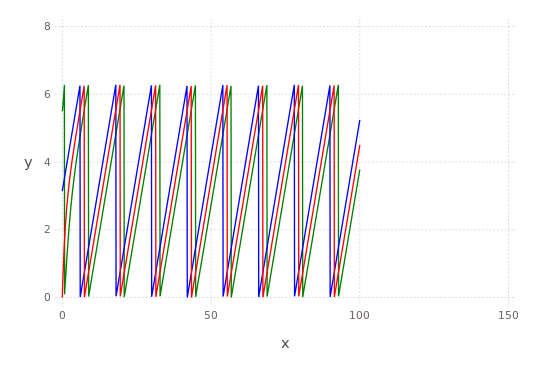

In [193]:
plot(
layer(x=grafdat[:,1],y=grafdat[:,2],Geom.line,Theme(line_width=1pt,default_color=color("red"))),
layer(x=grafdat[:,1],y=grafdat[:,3],Geom.line,Theme(line_width=1pt,default_color=color("blue"))),
layer(x=grafdat[:,1],y=grafdat[:,4],Geom.line,Theme(line_width=1pt,default_color=color("green"))))

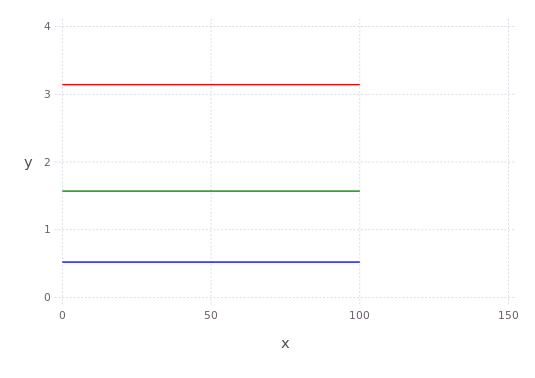

In [194]:
plot(
layer(x=grafdat[:,1],y=grafdat[:,5],Geom.line,Theme(line_width=1pt,default_color=color("red"))),
layer(x=grafdat[:,1],y=grafdat[:,6],Geom.line,Theme(line_width=1pt,default_color=color("blue"))),
layer(x=grafdat[:,1],y=grafdat[:,7],Geom.line,Theme(line_width=1pt,default_color=color("green"))))

In [33]:
grafdat[:,1]

LoadError: LoadError: UndefVarError: grafdat not defined
while loading In[33], in expression starting on line 1